# TOC

__Chapter 8 - Case study__

1. [Import](#Import)
1. [Facial recognition](#Facial-recognition)
    1. [EDA](#EDA)
    1. [Modeling](#Modeling)
        1. [Logistic regression on raw values](#Logistic-regression-on-raw-values)
        1. [Logistic regression with PCA](#Logistic-regression-with-PCA)

# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
from time import time
import importlib
import itertools
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.preprocessing as preprocessing
import sklearn.pipeline as pipeline
import sklearn.neighbors as neighbors
import sklearn.model_selection as model_selection
import sklearn.decomposition as decomposition
import sklearn.datasets as datasets
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.neural_network as neural_network
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

# Facial recognition

<a id = 'Facial-recognition'></a>

In [2]:
# load data
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
# capture dimensions
n_samples, h, w = lfw_people.images.shape

In [4]:
# create features and label
X = lfw_people.data
y = lfw_people.target
n_features = X.shape[1]

print(n_features)

1850


> Remarks - n_features has 1,850 columns because $50 \times 37 = 1,850$

In [5]:
# review loaded data
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("n samples: {}".format(n_samples))
print("n features: {}".format(n_features))
print("n classes: {}".format(n_classes))

n samples: 1288
n features: 1850
n classes: 7


## EDA

<a id = 'EDA'></a>

'Hugo Chavez'

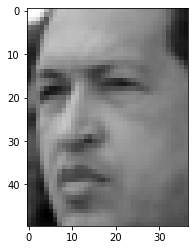

In [6]:
# plot first observation
plt.imshow(X[0].reshape((h, w)), cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

'Hugo Chavez'

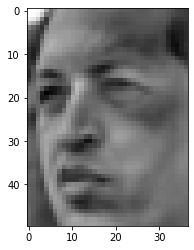

In [7]:
# plot first observation with scaling
plt.imshow(
    preprocessing.StandardScaler().fit_transform(X)[0].reshape((h, w)), cmap=plt.cm.gray
)
lfw_people.target_names[y[0]]

> Remarks - The pixels around the fact have darkened a bit after scaling

## Modeling

<a id = 'Modeling'></a>

In [8]:
# train/test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.25, random_state=1
)

In [9]:
# PCA pipeline

pca = decomposition.PCA(n_components=200, whiten=True)
prep = pipeline.Pipeline([("scale", preprocessing.StandardScaler()), ("pca", pca)])

print(
    "Extracting the top {:d} eigenfaces from {:d} faces".format(200, X_train.shape[0])
)

prep = prep.fit(X_train)
extracted_pca = prep.steps[1][1]

Extracting the top 200 eigenfaces from 966 faces


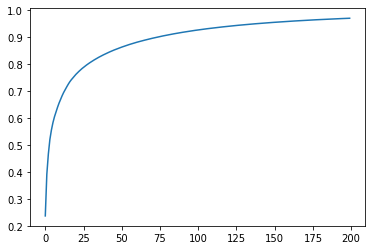

In [10]:
# visualize cumulative sum explained variance
plt.plot(np.cumsum(extracted_pca.explained_variance_ratio_))

In [11]:
# plot images of PCA components
comp = extracted_pca.components_
image_shape = (h, w)


def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)

    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray, vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.0)
    plt.show()

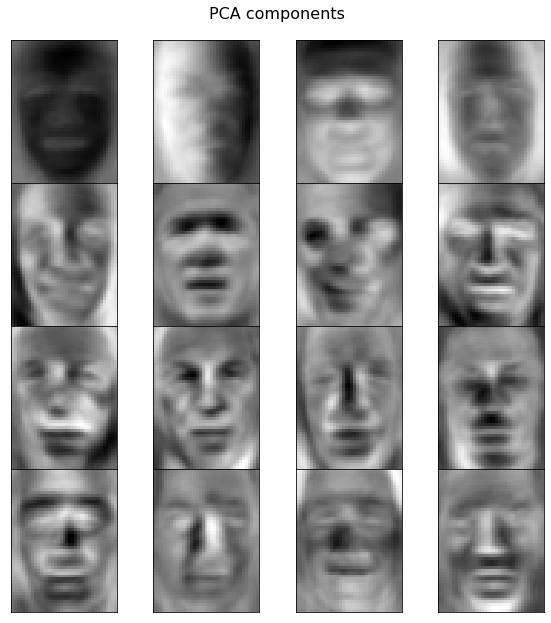

In [12]:
# gallery oc PCA components
plot_gallery("PCA components", comp[:16], 4, 4)

In [13]:
# plot prediction confusion matrix
import itertools


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Logistic regression on raw values

<a id = 'Logistic-regression-on-raw-values'></a>

In [14]:
# basic logistc regression
log_reg = linear_model.LogisticRegression()

t0 = time()

param_grid = {"C": [1e-2, 1e-1, 1e0, 1e1, 1e2]}
clf = model_selection.GridSearchCV(log_reg, param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

y_pred = best_clf.predict(X_test)

print("Accuracy of best estimator: {}".format(metrics.accuracy_score(y_pred, y_test)))
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

Accuracy of best estimator: 0.8136645962732919
                   precision    recall  f1-score   support

     Ariel Sharon       0.72      0.68      0.70        19
     Colin Powell       0.85      0.71      0.77        55
  Donald Rumsfeld       0.62      0.72      0.67        25
    George W Bush       0.88      0.91      0.89       142
Gerhard Schroeder       0.79      0.84      0.81        31
      Hugo Chavez       0.87      0.81      0.84        16
       Tony Blair       0.71      0.71      0.71        34

         accuracy                           0.81       322
        macro avg       0.78      0.77      0.77       322
     weighted avg       0.82      0.81      0.81       322



,0,1,2,3,4,5,6
0,13,1,3,1,0,0,1
1,2,39,1,8,0,2,3
2,1,0,18,5,0,0,1
3,2,2,3,129,6,0,0
4,0,0,1,0,26,0,4
5,0,1,0,0,1,13,1
6,0,3,3,4,0,0,24


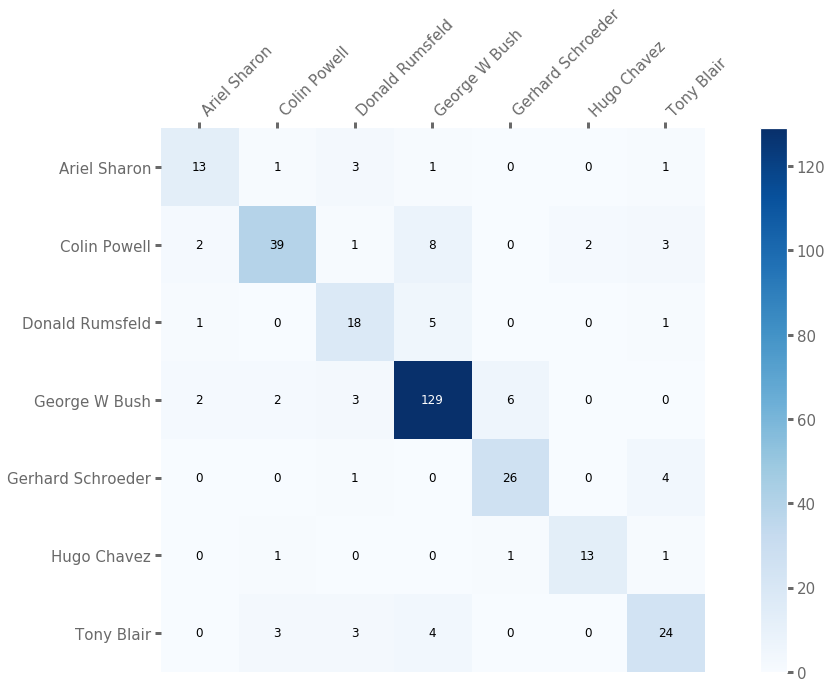

In [15]:
# visualize results with confusion matrix
p = PrettierPlot(chart_scale=20)
p.confusion_matrix(y_pred, y_test, labels=target_names)
plt.show()

### Logistic regression with PCA

<a id = 'Logistic-regression-with-PCA'></a>

In [16]:
# logistic regression workflow with PCA preprocessing
log_reg = linear_model.LogisticRegression()

t0 = time()

pipe = pipeline.Pipeline(
    [("PCA", decomposition.PCA(n_components=200)), ("logistic", log_reg)]
)

param_grid = {"logistic__C": [1e-2, 1e-1, 1e0, 1e1, 1e2]}
clf = model_selection.GridSearchCV(pipe, param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

y_pred = best_clf.predict(X_test)

print("Accuracy of best estimator: {}".format(metrics.accuracy_score(y_pred, y_test)))
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of best estimator: 0.7453416149068323
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.53      0.54        19
     Colin Powell       0.71      0.64      0.67        55
  Donald Rumsfeld       0.68      0.52      0.59        25
    George W Bush       0.79      0.91      0.84       142
Gerhard Schroeder       0.76      0.71      0.73        31
      Hugo Chavez       0.79      0.69      0.73        16
       Tony Blair       0.69      0.59      0.63        34

         accuracy                           0.75       322
        macro avg       0.71      0.65      0.68       322
     weighted avg       0.74      0.75      0.74       322



,0,1,2,3,4,5,6
0,10,3,1,4,0,0,1
1,3,35,1,12,0,2,2
2,1,0,13,11,0,0,0
3,3,5,1,129,3,1,0
4,0,1,2,1,22,0,5
5,0,2,0,1,1,11,1
6,1,3,1,6,3,0,20


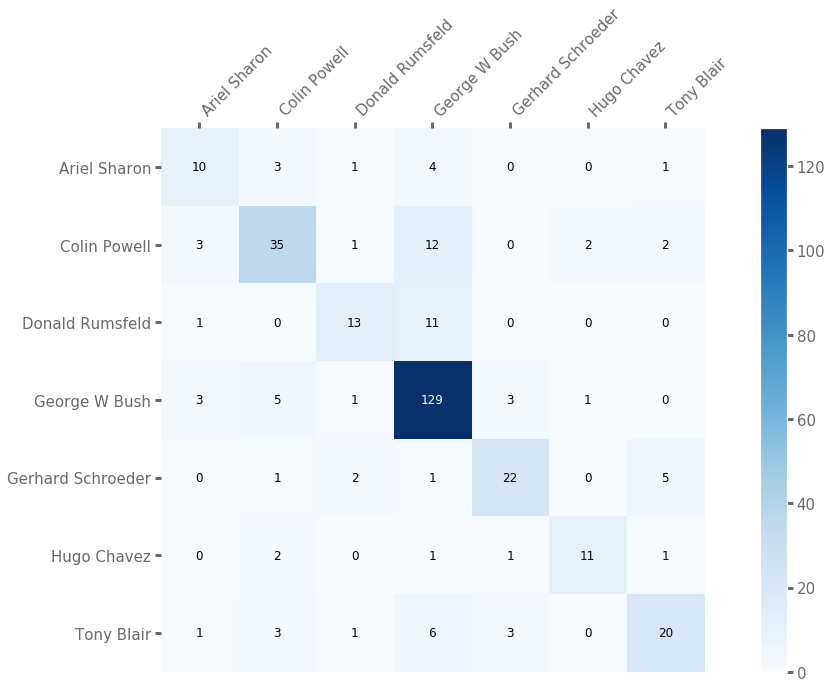

In [19]:
# visualize results with confusion matrix
p = PrettierPlot(chart_scale=20)
p.confusion_matrix(y_pred, y_test, labels=target_names)
plt.show()

> Remarks - The logistic regression model with PCA actually performed worse, which suggests that we should run a more comprehensive grid search over the number of PCA components.

### Logistic regression with PCA and LDA

In addition to performing PCA, we will add LDA to create features that best separate the faces from one another.

<a id = 'Logistic-regression-with-PCA-and-LDA'></a>

In [17]:
# custom function for cross validated grid search
def get_best_model_and_accuracy(model, params, X, y):
    grid = model_selection.GridSearchCV(model, params, error_score=0.0)
    grid.fit(X, y)

    print("Best Accuracy: {}".format(grid.best_score_))
    print("Best Parameters: {}".format(grid.best_params_))
    print(
        "Average Time to Fit (s): {}".format(
            round(grid.cv_results_["mean_fit_time"].mean(), 3)
        )
    )
    print(
        "Average Time to Score (s): {}".format(
            round(grid.cv_results_["mean_score_time"].mean(), 3)
        )
    )

In [18]:
# pipeline for performing both PCA and LDA
prep = pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("lda", discriminant_analysis.LinearDiscriminantAnalysis()),
    ]
)

# parameter grid
param_grid = {
    "logistic__C": [1e-2, 1e-1, 1e0, 1e1, 1e2],
    "prep__pca__n_components": [100, 150, 200, 250, 300],
    "prep__pca__whiten": [True, False],
    "prep__lda__n_components": range(1, 7),
}

# model pipeline
log_reg = linear_model.LogisticRegression()
pipe = pipeline.Pipeline([("prep", prep), ("logistic", log_reg)])

get_best_model_and_accuracy(pipe, param_grid, X, y)

Best Accuracy: 0.8385093167701864
Best Parameters: {'logistic__C': 10.0, 'prep__lda__n_components': 6, 'prep__pca__n_components': 150, 'prep__pca__whiten': True}
Average Time to Fit (s): 0.225
Average Time to Score (s): 0.01
